# Análise Estatística de Dados e Informações
**PPCA/UNB**

---

**Prova - Questão 01**  
**Professor**: João Gabriel de Moraes Sousa  
**Aluna**: Andreia Queiroz Correia Dummar  
**Matrícula**: 241134680  
**Data da Entrega**: 09/02/2025  
**Github**: 

---

**Aplicação**: Regressão Linear

**Dados**: House Sales in King County, USA (https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)

## 1) Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para manipulação de datas
from datetime import datetime

# Bibliotecas para estatística
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bibliotecas para normalização e padronização
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Biblioteca para divisão de dados
from sklearn.model_selection import train_test_split

# Bibliotecas para criação de modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Bibliotecas para avaliação de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2) Funções

In [2]:
def verificar_valores_faltantes(df):
    """
    Função para verificar valores faltantes em um DataFrame.

    Parâmetros:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Retorno:
        pd.DataFrame: DataFrame com as colunas e a quantidade de valores faltantes.
    """
    # Contar valores faltantes por coluna
    valores_faltantes = df.isnull().sum()
    
    # Filtrar apenas colunas com valores faltantes (ignorar valores zero)
    valores_faltantes = valores_faltantes[valores_faltantes > 0]
    
    # Criar DataFrame com as informações
    resultado = pd.DataFrame({
        'Coluna': valores_faltantes.index,
        'Valores Faltantes': valores_faltantes.values
    })
    
    # Ordenar pelo número de valores faltantes
    resultado = resultado.sort_values(by='Valores Faltantes', ascending=False).reset_index(drop=True)
    
    return resultado

In [3]:
def calcular_vif(df):
    """
    Calcula o VIF (Variance Inflation Factor) para todas as variáveis independentes em um DataFrame.

    Parâmetros:
    - df (DataFrame): DataFrame com as variáveis independentes (numéricas e categóricas dummificadas).

    Retorna:
    - DataFrame com as variáveis e seus respectivos VIFs.
    """
    # Adiciona uma constante para a regressão
    df = df.assign(constante=1)

    # Calcula o VIF para cada variável
    vif_data = pd.DataFrame()
    vif_data["Variável"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    # Remove a constante para o retorno
    return vif_data[vif_data["Variável"] != "constante"]

In [4]:
def criar_grafico_dispersao(df, coluna_x, coluna_y, cor="blue", tamanho_ponto=50):
    """
    Gera um gráfico de dispersão a partir de um DataFrame.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados.
    - coluna_x (str): Nome da coluna para o eixo X.
    - coluna_y (str): Nome da coluna para o eixo Y.
    - cor (str, opcional): Cor dos pontos. Padrão é "blue".
    - tamanho_ponto (int, opcional): Tamanho dos pontos no gráfico. Padrão é 50.

    Retorna:
    - Um gráfico de dispersão exibido na tela.
    """

    titulo = f"Gráfico de Dispersão - {coluna_x} X {coluna_y}"
    if coluna_x not in df.columns or coluna_y not in df.columns:
        raise ValueError(f"As colunas {coluna_x} e/ou {coluna_y} não estão no DataFrame.")

    plt.figure(figsize=(8 * 1.6, 6))
    plt.scatter(df[coluna_x], df[coluna_y], c=cor, s=tamanho_ponto, alpha=0.7)
    plt.title(titulo, fontsize=14)
    plt.xlabel(coluna_x, fontsize=12)
    plt.ylabel(coluna_y, fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [5]:
def criar_grafico_boxplot(df, coluna_x, coluna_y, cor="blue"):
    """
    Gera um gráfico boxplot a partir de um DataFrame.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados.
    - coluna_x (str): Nome da coluna para o eixo X (variável categórica).
    - coluna_y (str): Nome da coluna para o eixo Y (variável numérica).
    - cor (str, opcional): Cor dos boxplots. Padrão é "blue".

    Retorna:
    - Um gráfico boxplot exibido na tela.
    """

    titulo = f"Gráfico de Boxplot - {coluna_x} X {coluna_y}"
    if coluna_x not in df.columns or coluna_y not in df.columns:
        raise ValueError(f"As colunas {coluna_x} e/ou {coluna_y} não estão no DataFrame.")

    plt.figure(figsize=(8 * 1.6, 6))
    sns.boxplot(data=df, x=coluna_x, y=coluna_y, color=cor)
    plt.title(titulo, fontsize=14)
    plt.xlabel(coluna_x, fontsize=12)
    plt.ylabel(coluna_y, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


In [6]:
def criar_histograma(df, v_coluna, bins=30):
    """
    Cria um histograma para visualizar a distribuição da variável contínua.
    
    Parâmetros:
    - df: DataFrame contendo os dados
    - v_coluna: Nome da variável a ser plotada
    - bins: Número de bins para o histograma (padrão: 30)
    """
    plt.figure(figsize=(8,5))
    sns.histplot(df[v_coluna], bins=bins, kde=True, color='blue')
    plt.xlabel(v_coluna)
    plt.ylabel("Frequência")
    plt.title(f"Histograma da variável {v_coluna}")
    plt.show()

In [7]:
def exibir_valores_e_quantidades(df, coluna):
    """
    Exibe os valores únicos de uma coluna e a quantidade de registros para cada valor.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados.
    - coluna (str): Nome da coluna para análise.

    Retorna:
    - Um DataFrame com os valores únicos e suas contagens.
    """
    if coluna not in df.columns:
        raise ValueError(f"A coluna {coluna} não está no DataFrame.")

    contagens = df[coluna].value_counts().reset_index()
    contagens.columns = [coluna, 'Quantidade']
    return contagens


In [8]:
def realizar_anova(df, variavel_quantitativa, variavel_categorica):
    """
    Realiza o teste ANOVA em um DataFrame.

    Parâmetros:
    - df (DataFrame): O DataFrame contendo os dados.
    - variavel_quantitativa (str): Nome da coluna com a variável quantitativa (dependente).
    - variavel_categorica (str): Nome da coluna com a variável categórica (independente).

    Retorna:
    - Um dicionário com os resultados do teste ANOVA (F-statistic e p-value).
    
    Exemplo:
    realizar_anova(df, "altura", "grupo")
    """
    # Verifica se as colunas existem no DataFrame
    if variavel_quantitativa not in df.columns or variavel_categorica not in df.columns:
        raise ValueError(f"As colunas {variavel_quantitativa} e/ou {variavel_categorica} não estão no DataFrame.")

    # Agrupa os dados por categorias
    grupos = [grupo[variavel_quantitativa].dropna() for nome, grupo in df.groupby(variavel_categorica)]

    # Realiza o teste ANOVA
    f_statistic, p_value = stats.f_oneway(*grupos)

    # Retorna os resultados
    return {
        "F-statistic": f_statistic,
        "p-value": p_value
    }




In [9]:
def analise_variavel_categorica(df, v_coluna):
    """
    Realiza a análise de uma variável categórica em relação à variável alvo 'price'.

    Parâmetros:
    - df: DataFrame contendo os dados
    - v_coluna: Nome da variável categórica a ser analisada
    """

    print(df[[v_coluna]].describe())
    
    print("______________________________________________________________________________________________")

    # Chamando a função para criar gráfico de dispersão
    criar_grafico_dispersao(df, v_coluna, 'price')
    
    print("______________________________________________________________________________________________")

    correlacao, p_valor = stats.pearsonr(df[v_coluna], df["price"])
    print(f"Correlação de Pearson: {correlacao:.3f} (p-valor: {p_valor:.3f})")
    
    print("______________________________________________________________________________________________")

    criar_grafico_boxplot(df, v_coluna, 'price')
    
    contagens = exibir_valores_e_quantidades(df, v_coluna)
    print(contagens)
    
    print("______________________________________________________________________________________________")

    resultado = realizar_anova(df, 'price', v_coluna)
    print(f"Resultado ANOVA: {resultado}")
    
    print("______________________________________________________________________________________________")


In [10]:
def analise_variavel_continua(df, v_coluna):
    """
    Realiza a análise de uma variável contínua em relação à variável alvo 'price'.

    Parâmetros:
    - df: DataFrame contendo os dados
    - v_coluna: Nome da variável contínua a ser analisada
    """

    print(df[[v_coluna]].describe())
    
    print("______________________________________________________________________________________________")

    # Chamando a função para criar gráfico de dispersão
    criar_grafico_dispersao(df, v_coluna, 'price')
    
    print("______________________________________________________________________________________________")

    correlacao, p_valor = stats.pearsonr(df[v_coluna], df["price"])
    print(f"Correlação de Pearson: {correlacao:.3f} (p-valor: {p_valor:.3f})")
    
    print("______________________________________________________________________________________________")

    criar_histograma(df, v_coluna)
    
    print("______________________________________________________________________________________________")

    

In [11]:
def executar_regressao_linear(df, variaveis_independentes, variavel_dependente):
    """
    Executa uma regressão linear, normaliza os dados e exibe os indicadores de desempenho.

    Parâmetros:
    - df: DataFrame contendo os dados
    - variaveis_independentes: Lista com os nomes das colunas independentes
    - variavel_dependente: Nome da coluna dependente

    Retorna:
    - Modelo treinado e as métricas de desempenho
    """
    # Separando variáveis independentes (X) e dependente (y)
    X = df[variaveis_independentes]
    y = df[variavel_dependente]

    # Dividindo os dados em treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalizando os dados (Padronização Z-score)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Criando e treinando o modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Fazendo previsões
    y_pred = modelo.predict(X_test)

    # Calculando métricas de desempenho
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Exibindo os resultados
    print("Indicadores do Modelo de Regressão Linear:")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"🔹 R² Score: {r2:.4f}")

    # Verificação da linearidade
    plt.figure(figsize=(8, 5))
    sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, line_kws={"color": "red"})
    plt.xlabel("Valores Preditos")
    plt.ylabel("Resíduos")
    plt.title("Análise de Resíduos - Verificação da Linearidade")
    plt.show()
    
    return modelo


In [12]:
def executar_arvore_decisao(df, variaveis_independentes, variavel_dependente, max_depth=None):
    """
    Executa um modelo de árvore de decisão para regressão e exibe os indicadores de desempenho.

    Parâmetros:
    - df: DataFrame contendo os dados
    - variaveis_independentes: Lista com os nomes das colunas independentes
    - variavel_dependente: Nome da coluna dependente
    - max_depth: Profundidade máxima da árvore (opcional, padrão: None)

    Retorna:
    - Modelo treinado, previsões e as métricas de desempenho
    """
    # Separando variáveis independentes (X) e dependente (y)
    X = df[variaveis_independentes]
    y = df[variavel_dependente]

    # Dividindo os dados em treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criando e treinando o modelo de árvore de decisão
    modelo = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    modelo.fit(X_train, y_train)

    # Fazendo previsões
    y_pred = modelo.predict(X_test)

    # Calculando métricas de desempenho
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Exibindo os resultados
    print("Indicadores do Modelo de Árvore de Decisão:")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"🔹 R² Score: {r2:.4f}")
    
    return modelo, y_pred, {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

In [13]:
def executar_random_forest(df, variaveis_independentes, variavel_dependente, n_estimators=100, max_depth=None):
    """
    Executa um modelo Random Forest para regressão e exibe os indicadores de desempenho.
    """
    X = df[variaveis_independentes]
    y = df[variavel_dependente]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    modelo = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Indicadores do Modelo Random Forest:")
    print(f"🔹 MAE: {mae:.2f}")
    print(f"🔹 MSE: {mse:.2f}")
    print(f"🔹 RMSE: {rmse:.2f}")
    print(f"🔹 R² Score: {r2:.4f}")
    
    return modelo, y_pred, {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

## 3) Leitura do arquivo

In [14]:
diretorio = './dados'

house_sales_data = pd.read_csv(f'{diretorio}/kc_house_data.csv', delimiter=',')

house_sales_data.shape

(21613, 21)

## 4) Análise descritiva

### 4.1) Análise geral

In [15]:
house_sales_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [16]:
house_sales_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [17]:
# Criar um novo DataFrame sem a coluna 'date'
house_sales_data_01 = house_sales_data.drop(columns=['date'])

house_sales_data_01.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [18]:
house_sales_data_01.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 4.2) Verificar valores faltantes

In [19]:
result = verificar_valores_faltantes(house_sales_data_01)

if result.empty:
    print("Não há valores faltantes")
else:
    result.head(100)

Não há valores faltantes


### 4.3) Calcular o VIF (Variance Inflation Factor)

O Variance Inflation Factor (VIF) é uma métrica usada para identificar multicolinearidade entre variáveis independentes em um modelo de regressão. Ele mede o quanto a variância de um coeficiente de regressão aumenta devido à correlação entre as variáveis. Um **VIF próximo de 1 indica baixa correlação**, enquanto **valores acima de 5 ou 10 sugerem multicolinearidade significativa**, podendo prejudicar a interpretação dos coeficientes do modelo.

In [20]:
calcular_vif(house_sales_data_01)

C:\Users\aqcor\anaconda3\envs\PPCA_AEDI\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\aqcor\anaconda3\envs\PPCA_AEDI\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Variável,VIF
0,id,1.028540
1,price,3.331627
2,bedrooms,1.679412
3,bathrooms,3.375632
4,sqft_living,inf
5,sqft_lot,2.109020
6,floors,2.012361
7,waterfront,1.266632
8,view,1.477115
9,condition,1.257235


---

#### Análise do Variance Inflation Factor (VIF)

A análise do **Variance Inflation Factor (VIF)** indica a presença de **multicolinearidade severa** nas variáveis `sqft_living`, `sqft_above` e `sqft_basement`, pois seus valores de VIF são **infinitos (`inf`)**. Isso sugere que essas variáveis estão altamente correlacionadas com outras no conjunto de dados, possivelmente sendo **combinações lineares** entre si. Sendo assim, para o modelo será utilizado apenas a `sqft_living`.

Para as demais variáveis, serão consideradas para análise todas que possuem VIF menor que 2, exceto `ID` que é o identificaro do registro: `bedrooms`, `waterfront`, `view`, `condition`, `yr_renovated`, `zipcode`, `lat` e `long`.


---

### 4.4) Análise das colunas

#### 4.4.1) Variável `bedrooms`

           bedrooms
count  21613.000000
mean       3.370842
std        0.930062
min        0.000000
25%        3.000000
50%        3.000000
75%        4.000000
max       33.000000
______________________________________________________________________________________________


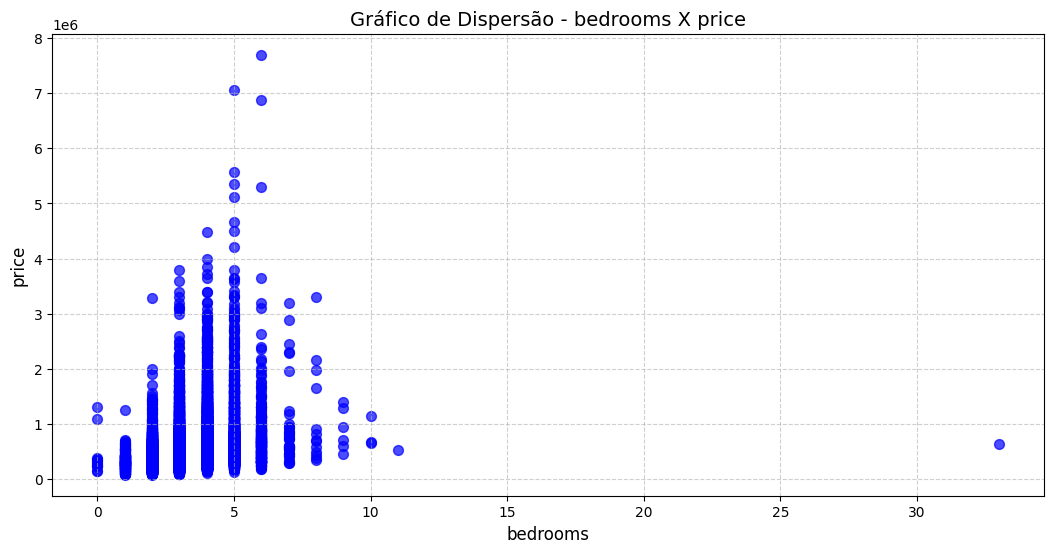

______________________________________________________________________________________________
Correlação de Pearson: 0.308 (p-valor: 0.000)
______________________________________________________________________________________________


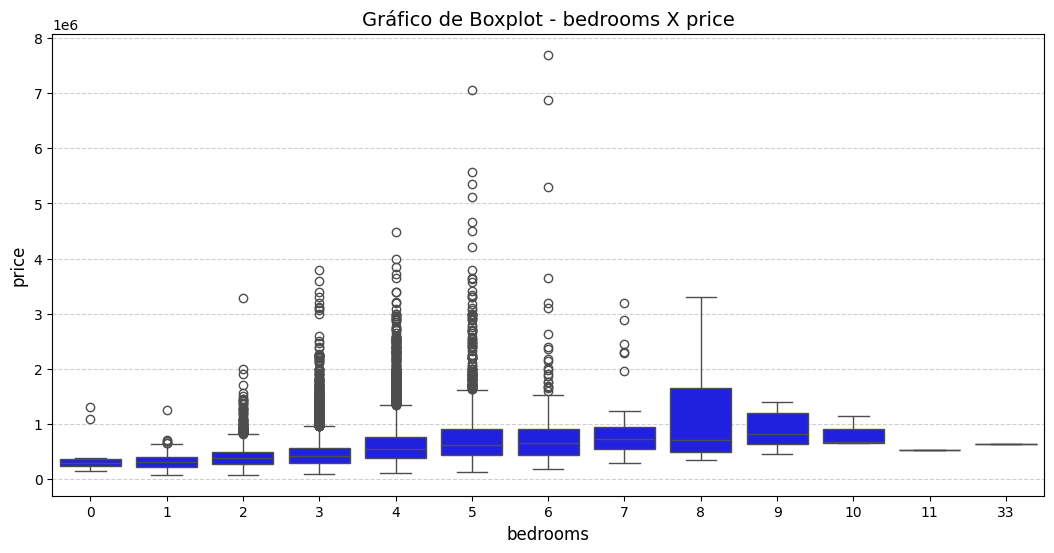

    bedrooms  Quantidade
0          3        9824
1          4        6882
2          2        2760
3          5        1601
4          6         272
5          1         199
6          7          38
7          0          13
8          8          13
9          9           6
10        10           3
11        11           1
12        33           1
______________________________________________________________________________________________
Resultado ANOVA: {'F-statistic': np.float64(214.62657916834172), 'p-value': np.float64(0.0)}
______________________________________________________________________________________________


In [21]:
analise_variavel_categorica(house_sales_data_01, 'bedrooms')

**Análise da Variável `bedrooms` para Regressão Linear**

- **Distribuição**: A maioria das casas tem **3 ou 4 quartos**, com alguns outliers (máximo de 33 quartos).
- **Correlação de Pearson**: `0.308` (p-valor `0.000`), indicando uma **relação fraca a moderada** com o preço.
- **ANOVA**: F-statistic `214.63` (p-valor `0.0`), mostrando diferença significativa entre os grupos de quartos.

Embora `bedrooms` tenha uma relação estatisticamente significativa com o preço, sua correlação **não é forte o suficiente** para ser um bom preditor em uma **regressão linear simples**. No entanto, considerando que ao combiná-la com outras variáveis, pode contribuir para melhorar a previsão, a variável será utilizada no modelo.

---

#### 4.4.2) Variável `waterfront`

         waterfront
count  21613.000000
mean       0.007542
std        0.086517
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
______________________________________________________________________________________________


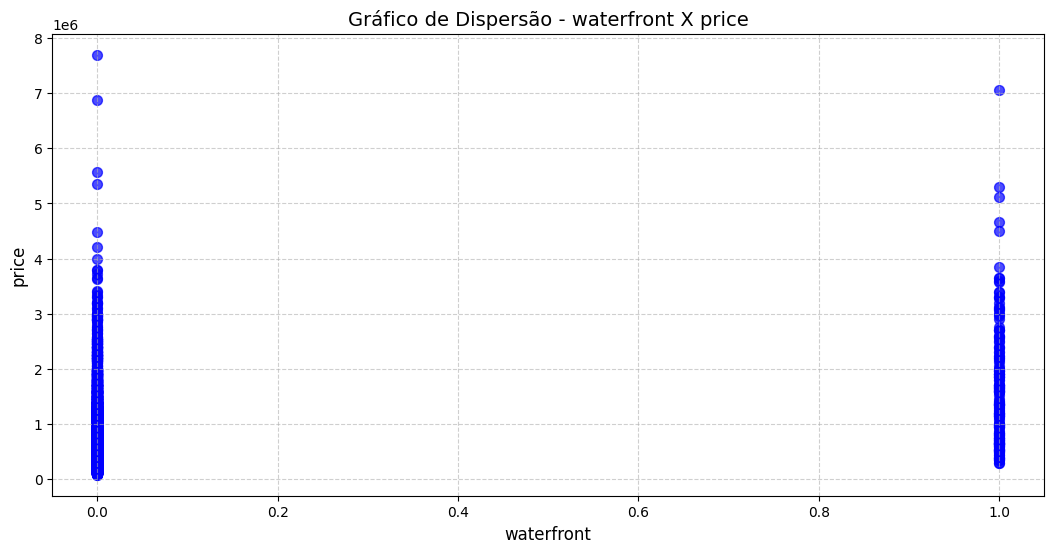

______________________________________________________________________________________________
Correlação de Pearson: 0.266 (p-valor: 0.000)
______________________________________________________________________________________________


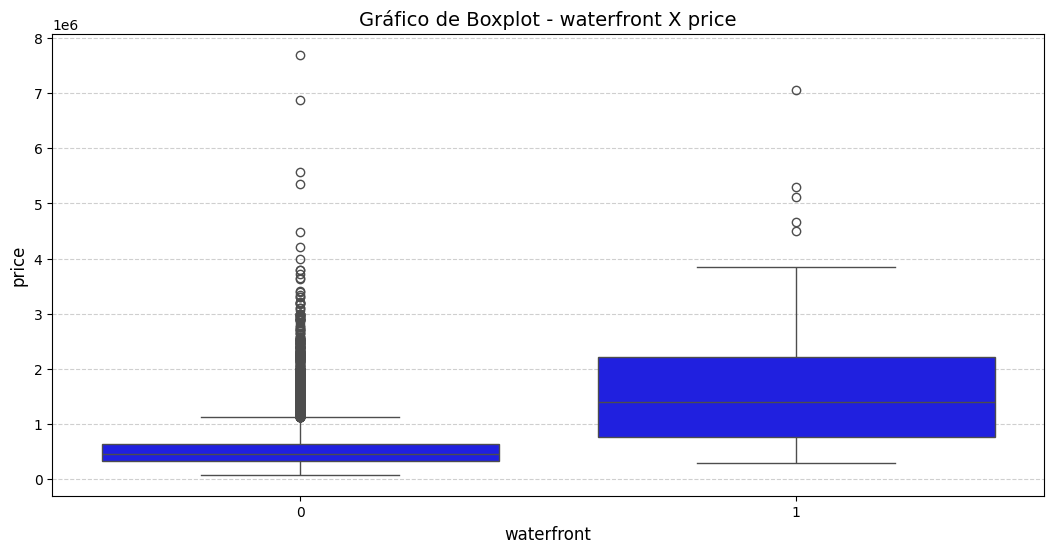

   waterfront  Quantidade
0           0       21450
1           1         163
______________________________________________________________________________________________
Resultado ANOVA: {'F-statistic': np.float64(1650.463035775797), 'p-value': np.float64(0.0)}
______________________________________________________________________________________________


In [22]:
analise_variavel_categorica(house_sales_data_01, 'waterfront')

**Análise da Variável `waterfront` para Regressão Linear**

- **Distribuição**: A grande maioria das casas **não possui vista para a água** (`0` = 21.450, `1` = 163), tornando a variável altamente desbalanceada.
- **Correlação de Pearson**: `0.266` (p-valor `0.000`), indicando uma **relação positiva, porém fraca**, com o preço.
- **ANOVA**: F-statistic `1650.46` (p-valor `0.0`), mostrando uma **diferença estatisticamente significativa** nos preços entre os grupos.

Considerando que está altamente desbalanceada, 21550 (categoria 0) X 161 (categoria 1), ela não será utilizada no modelo.

---

#### 4.4.3) Variável `view`

               view
count  21613.000000
mean       0.234303
std        0.766318
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
______________________________________________________________________________________________


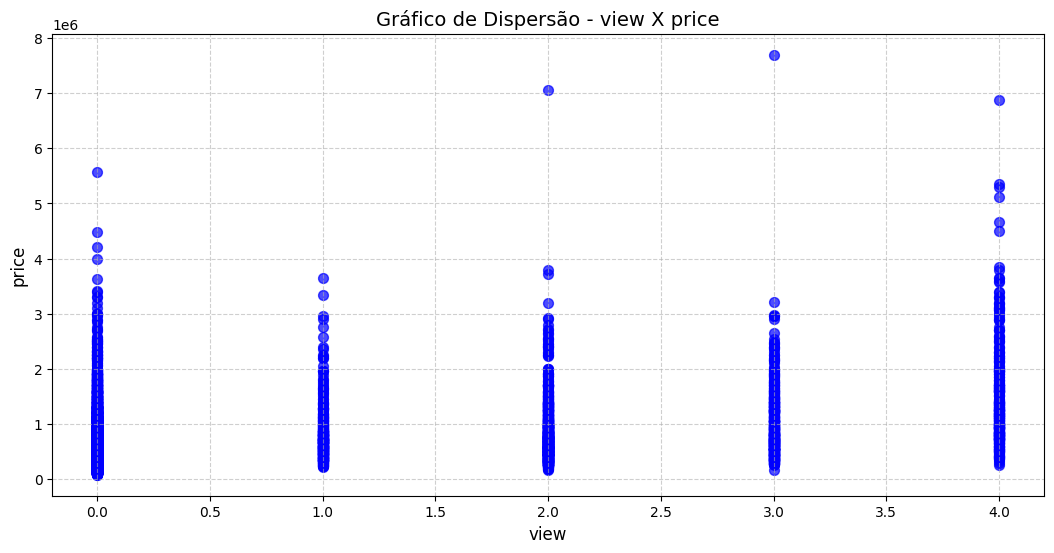

______________________________________________________________________________________________
Correlação de Pearson: 0.397 (p-valor: 0.000)
______________________________________________________________________________________________


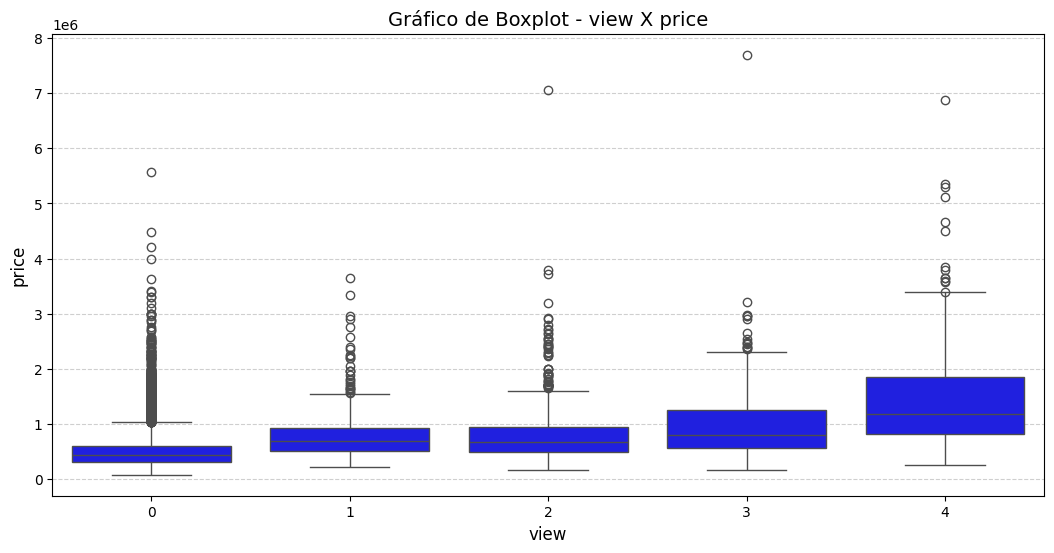

   view  Quantidade
0     0       19489
1     2         963
2     3         510
3     1         332
4     4         319
______________________________________________________________________________________________
Resultado ANOVA: {'F-statistic': np.float64(1092.688222523648), 'p-value': np.float64(0.0)}
______________________________________________________________________________________________


In [23]:
analise_variavel_categorica(house_sales_data_01, 'view')

**Análise da Variável `view` para Regressão Linear**

- **Distribuição**: A maioria das casas **não possui uma vista privilegiada** (`0` = 19.489), enquanto poucas têm avaliações mais altas (`4` = 319).
- **Correlação de Pearson**: `0.397` (p-valor `0.000`), indicando uma **correlação moderada positiva** com o preço.
- **ANOVA**: F-statistic `1092.69` (p-valor `0.0`), mostrando uma **diferença estatisticamente significativa** nos preços entre os diferentes níveis de `view`.

A variável `view` tem **impacto relevante no preço**, apresentando uma correlação **moderada** e estatisticamente significativa. Apesar da concentração em `0`, os níveis mais altos podem indicar um diferencial de preço. Portanto, essa variável será utilizada no modelo.

---


#### 4.4.4) Variável `condition`

          condition
count  21613.000000
mean       3.409430
std        0.650743
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
______________________________________________________________________________________________


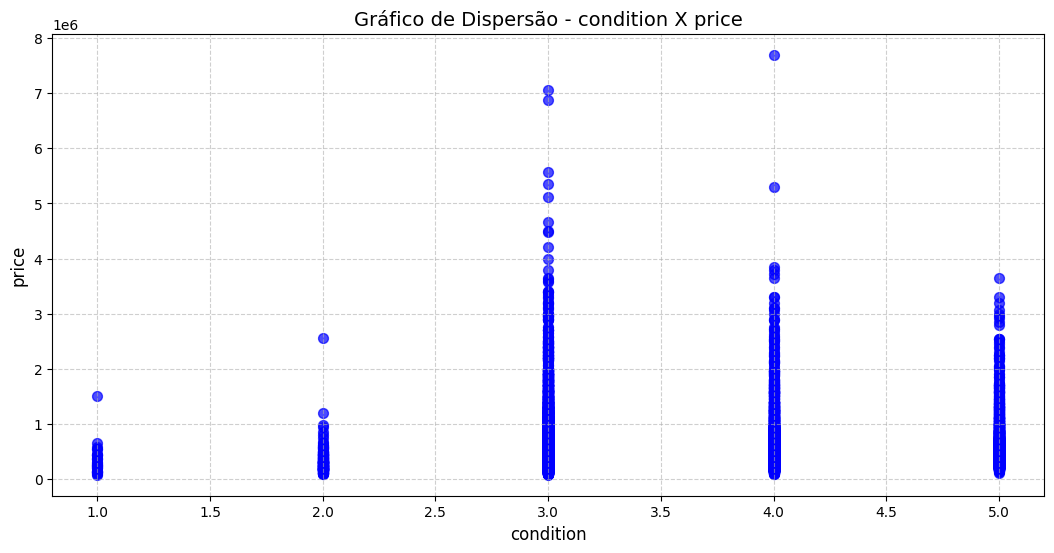

______________________________________________________________________________________________
Correlação de Pearson: 0.036 (p-valor: 0.000)
______________________________________________________________________________________________


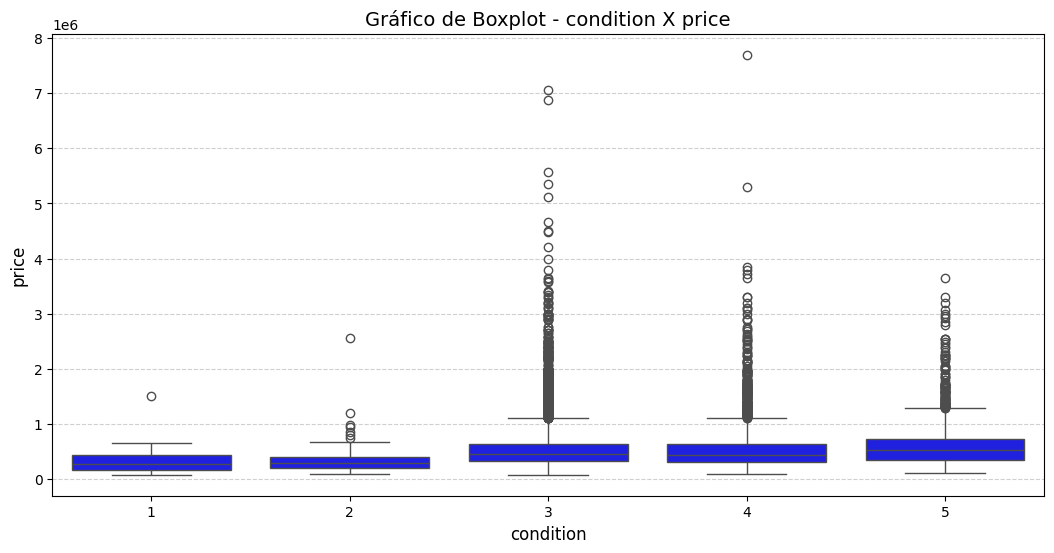

   condition  Quantidade
0          3       14031
1          4        5679
2          5        1701
3          2         172
4          1          30
______________________________________________________________________________________________
Resultado ANOVA: {'F-statistic': np.float64(37.411540021423356), 'p-value': np.float64(3.116011341857883e-31)}
______________________________________________________________________________________________


In [24]:
analise_variavel_categorica(house_sales_data_01, 'condition')

**Análise da Variável `condition` para Regressão Linear**

- **Distribuição**: A maioria das casas está em **condição mediana (`3` = 14.031)**, com poucas em estados extremos (`1` = 30, `5` = 1.701).
- **Correlação de Pearson**: `0.036` (p-valor `0.000`), indicando uma **relação muito fraca** com o preço.
- **ANOVA**: F-statistic `37.41` (p-valor `3.12e-31`), mostrando uma **diferença estatisticamente significativa** entre os grupos, mas de baixa magnitude.

Apesar de `condition` ter um impacto estatisticamente significativo no preço, considerando sua **correlação extremamente fraca (`0.036`)** ela não será utilizada no modelo.

---


#### 4.4.5) Variável `yr_renovated`

       yr_renovated
count  21613.000000
mean      84.402258
std      401.679240
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max     2015.000000
______________________________________________________________________________________________


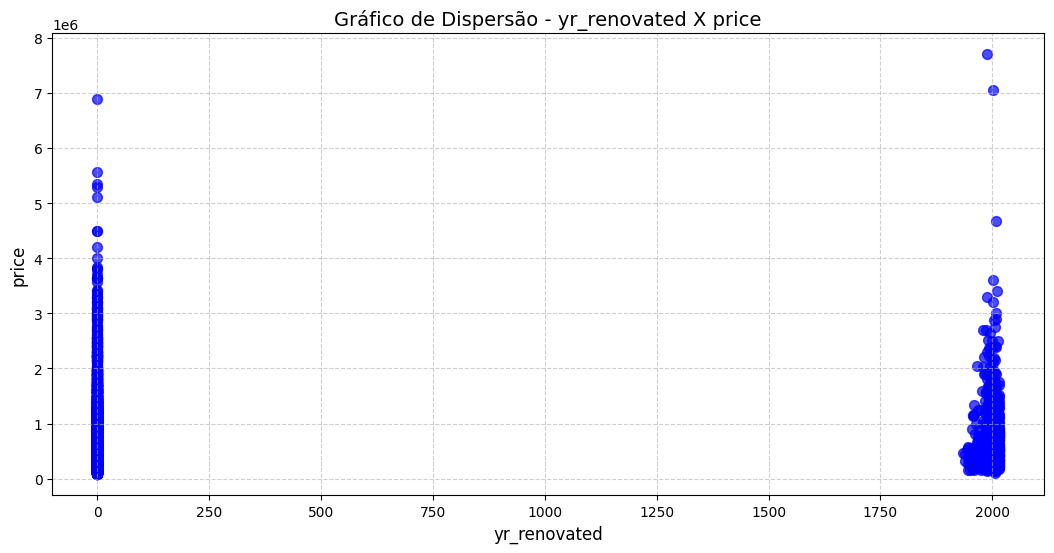

______________________________________________________________________________________________
Correlação de Pearson: 0.126 (p-valor: 0.000)
______________________________________________________________________________________________


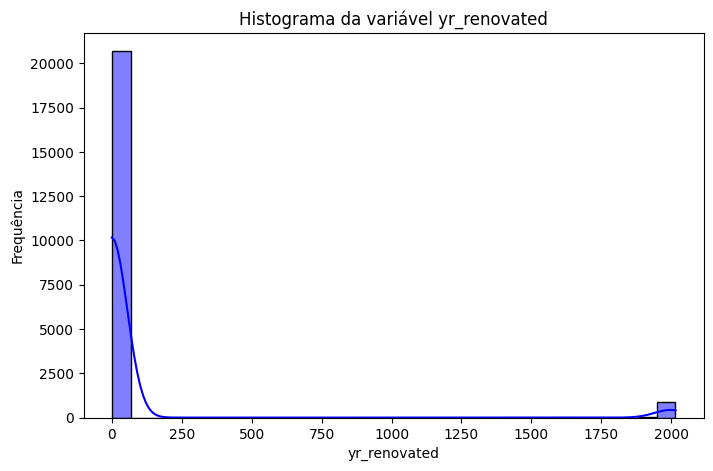

______________________________________________________________________________________________


In [25]:
analise_variavel_continua(house_sales_data_01, 'yr_renovated')

**Análise da Variável `yr_renovated` para Regressão Linear**

- **Distribuição**: A maioria das casas **nunca foi renovada** (`yr_renovated = 0` em pelo menos 75% dos casos), com poucas apresentando valores de renovação maiores.
- **Correlação de Pearson**: `0.126` (p-valor `0.000`), indicando uma **correlação fraca, porém estatisticamente significativa**, com o preço.

A variável `yr_renovated` tem **baixo impacto linear no preço**, pois a correlação é fraca e a maioria das casas não foi renovada, não será utilizada no modelo.

---


#### 4.4.6) Variável `zipcode`

            zipcode
count  21613.000000
mean   98077.939805
std       53.505026
min    98001.000000
25%    98033.000000
50%    98065.000000
75%    98118.000000
max    98199.000000
______________________________________________________________________________________________


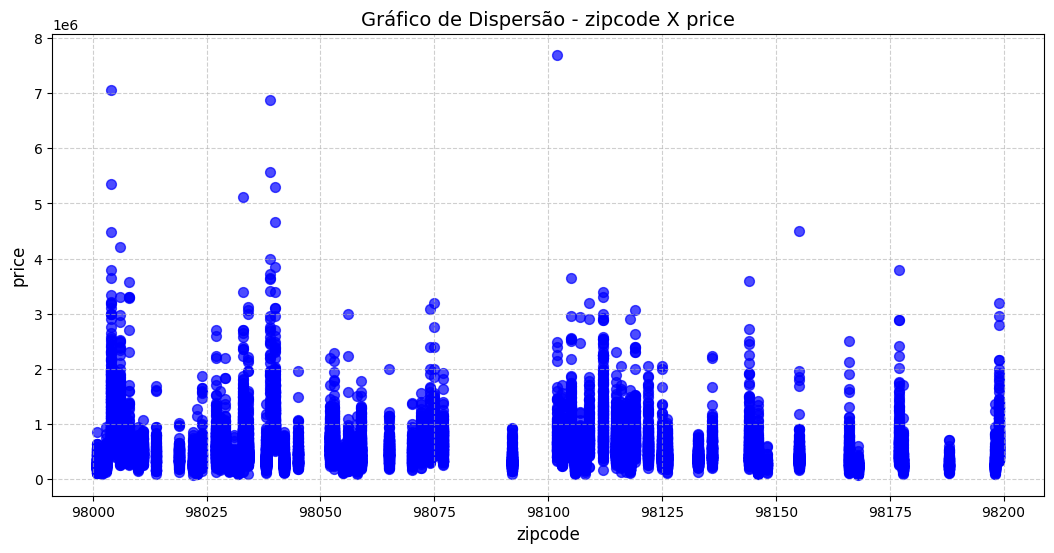

______________________________________________________________________________________________
Correlação de Pearson: -0.053 (p-valor: 0.000)
______________________________________________________________________________________________


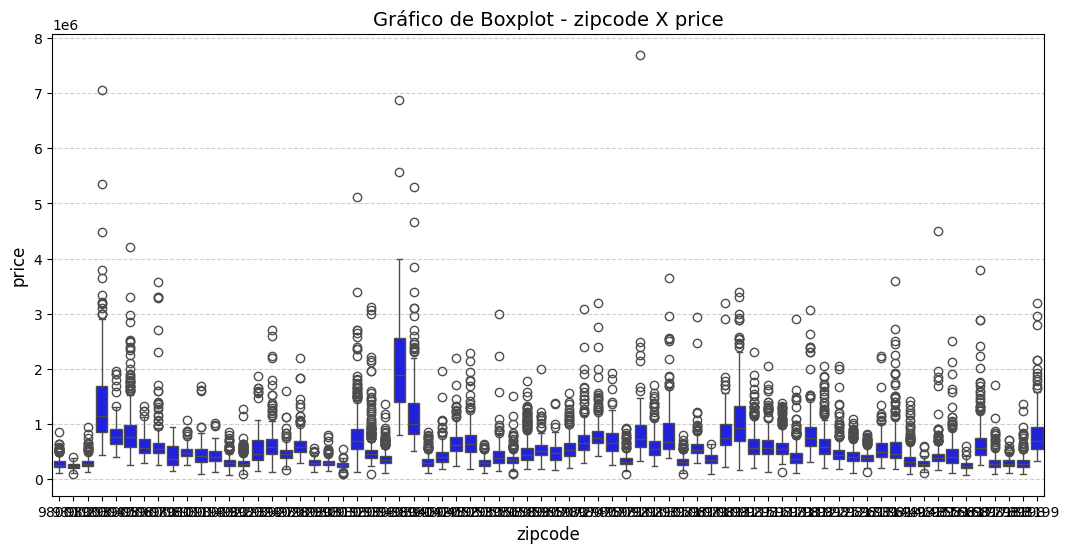

    zipcode  Quantidade
0     98103         602
1     98038         590
2     98115         583
3     98052         574
4     98117         553
..      ...         ...
65    98102         105
66    98010         100
67    98024          81
68    98148          57
69    98039          50

[70 rows x 2 columns]
______________________________________________________________________________________________
Resultado ANOVA: {'F-statistic': np.float64(214.63278674208243), 'p-value': np.float64(0.0)}
______________________________________________________________________________________________


In [26]:
analise_variavel_categorica(house_sales_data_01, 'zipcode')

**Análise da Variável `zipcode` para Regressão Linear**

- **Distribuição**: A variável `zipcode` representa códigos postais, distribuídos entre `98001` e `98199`, com média `98077.94` e baixo desvio padrão (`53.51`). Existem **70 valores distintos**, sendo os mais frequentes `98103`, `98038` e `98115`.
- **Correlação de Pearson**: `-0.053` (p-valor `0.000`), indicando uma **correlação negativa muito fraca**, porém estatisticamente significativa, com o preço.
- **ANOVA**: F-statistic `214.63` (p-valor `0.0`), mostrando **diferença estatisticamente significativa** entre os grupos de `zipcode`.

A variável `zipcode` **não apresenta uma relação linear forte com o preço** (correlação fraca), mas a análise de variância indica que diferentes regiões influenciam os preços. Será utilizada no modelo.

---


#### 4.4.7) Variável `lat`

                lat
count  21613.000000
mean      47.560053
std        0.138564
min       47.155900
25%       47.471000
50%       47.571800
75%       47.678000
max       47.777600
______________________________________________________________________________________________


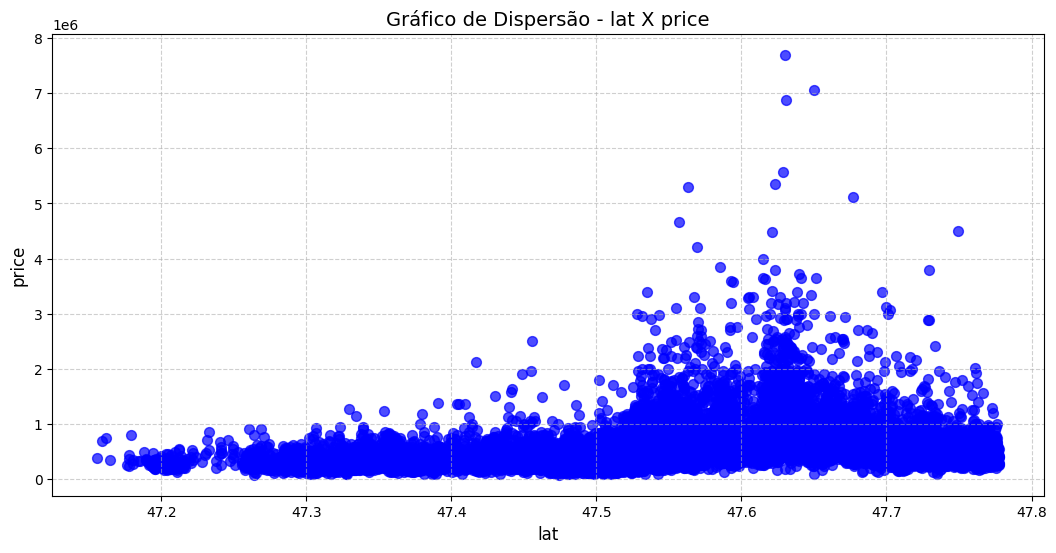

______________________________________________________________________________________________
Correlação de Pearson: 0.307 (p-valor: 0.000)
______________________________________________________________________________________________


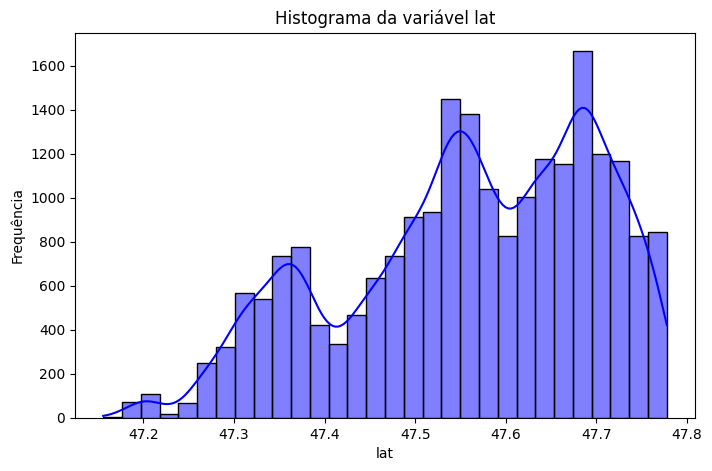

______________________________________________________________________________________________


In [27]:
analise_variavel_continua(house_sales_data_01, 'lat')

**Análise da Variável `lat` para Regressão Linear**

- **Distribuição**: A latitude varia entre `47.1559` e `47.7776`, com média `47.56` e desvio padrão `0.1386`, indicando que os imóveis estão concentrados em uma região geograficamente limitada.
- **Correlação de Pearson**: `0.307` (p-valor `0.000`), mostrando uma **correlação moderada positiva** e estatisticamente significativa com o preço.

A variável `lat` tem um impacto **estatisticamente significativo** e apresenta **correlação moderada** com o preço, sugerindo que a localização geográfica influencia os valores dos imóveis.Será utilizada no modelo.

---


#### 4.4.8) Variável `long`

               long
count  21613.000000
mean    -122.213896
std        0.140828
min     -122.519000
25%     -122.328000
50%     -122.230000
75%     -122.125000
max     -121.315000
______________________________________________________________________________________________


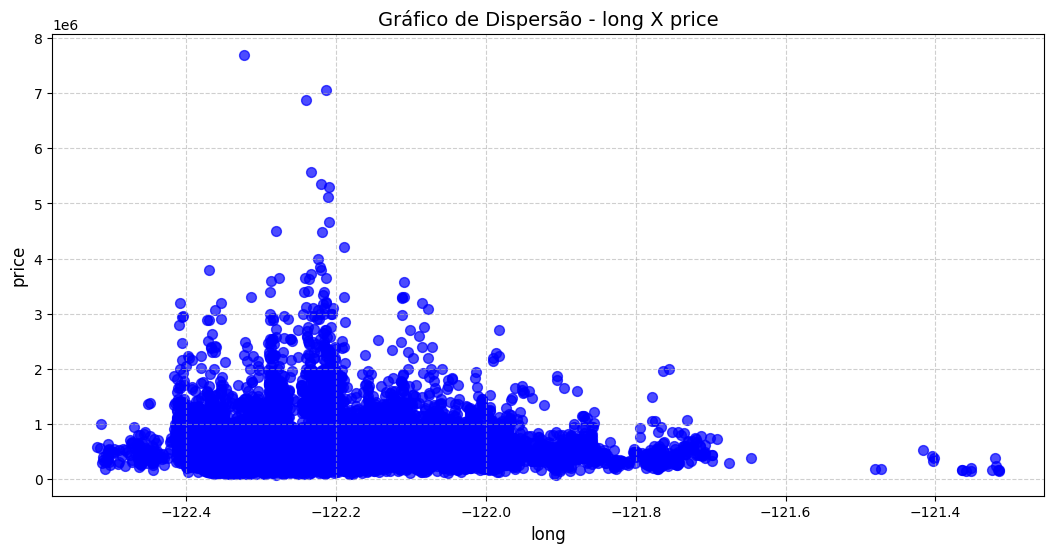

______________________________________________________________________________________________
Correlação de Pearson: 0.022 (p-valor: 0.001)
______________________________________________________________________________________________


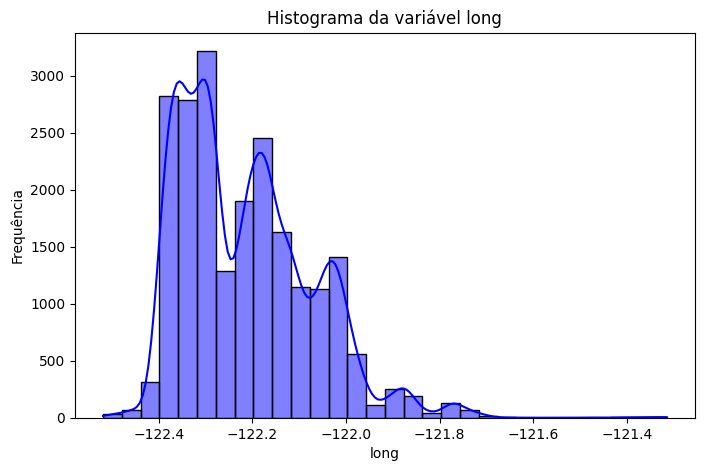

______________________________________________________________________________________________


In [28]:
analise_variavel_continua(house_sales_data_01, 'long')

### 4.5) Cria dataframe e normaliza dados para utilização no modelo de regressão linear

**Análise da Variável `long` para Regressão Linear**

- **Distribuição**: A longitude varia entre `-122.519` e `-121.315`, com média `-122.214` e desvio padrão `0.1408`, indicando que os imóveis estão concentrados em uma região geograficamente limitada.
- **Correlação de Pearson**: `0.022` (p-valor `0.001`), sugerindo uma **correlação extremamente fraca**, embora estatisticamente significativa.

A variável `long` tem um **impacto insignificante** no preço, dada sua correlação quase nula. Não será utilizada no modelo.

---


In [29]:
# Gera um dataset com as colunas selecionadas para o modelo
# Criando um novo DataFrame com as colunas selecionadas
house_sales_data_modelo = house_sales_data_01[['price', 'sqft_living', 'bedrooms', 'view', 'zipcode', 'lat']]

# Exibir as primeiras linhas para conferência
house_sales_data_modelo.head()

,price,sqft_living,bedrooms,view,zipcode,lat
0,221900.0,1180,3,0,98178,47.5112
1,538000.0,2570,3,0,98125,47.7210
2,180000.0,770,2,0,98028,47.7379
3,604000.0,1960,4,0,98136,47.5208
4,510000.0,1680,3,0,98074,47.6168


In [30]:
# Normaliza o dataframe

scaler = MinMaxScaler()
house_sales_data_modelo_normalizado = house_sales_data_modelo.copy()
house_sales_data_modelo_normalizado[['price', 'sqft_living', 'bedrooms', 'zipcode', 'lat']] = scaler.fit_transform(house_sales_data_modelo[['price', 'sqft_living', 'bedrooms', 'zipcode', 'lat']])

house_sales_data_modelo_normalizado.head()


,price,sqft_living,bedrooms,view,zipcode,lat
0,0.019266,0.067170,0.090909,0,0.893939,0.571498
1,0.060721,0.172075,0.090909,0,0.626263,0.908959
2,0.013770,0.036226,0.060606,0,0.136364,0.936143
3,0.069377,0.126038,0.121212,0,0.681818,0.586939
4,0.057049,0.104906,0.090909,0,0.368687,0.741354


## 5) Construção do modelo de regressão linear

### 5.1) Executando o modelo

Indicadores do Modelo de Regressão Linear:
🔹 Mean Absolute Error (MAE): 0.02
🔹 Mean Squared Error (MSE): 0.00
🔹 Root Mean Squared Error (RMSE): 0.03
🔹 R² Score: 0.6143


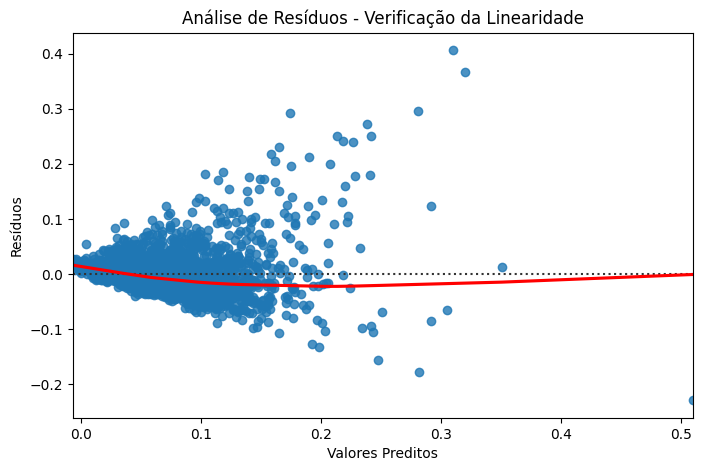

In [31]:
modelo = executar_regressao_linear(house_sales_data_modelo_normalizado, ['sqft_living', 'bedrooms', 'view', 'zipcode', 'lat'], 'price')

---

**Análise dos Indicadores do Modelo de Regressão Linear**

- **MAE**: `0.02` → Erro médio absoluto baixo, indicando previsões próximas aos valores reais.  
- **MSE**: `0.00` → Erro quadrático médio muito pequeno, sugerindo poucos erros grandes.  
- **RMSE**: `0.03` → Indica um bom ajuste do modelo.  
- **R² Score**: `0.6143` → O modelo explica **61.43% da variação do preço**.  

Embora o modelo apresente **erros baixos**, o **R² de 0.6143** indica que ainda há **38.57% da variação do preço não explicada**. Além disso, a dispersão dos resíduos **não é completamente aleatória**, sugerindo **possível não linearidade** no modelo. Também há sinais de **heterocedasticidade**, pois a variância dos resíduos aumenta conforme os valores preditos crescem, caracterizando um **padrão de funil**.

---


### 5.2) Melhorando o modelo

#### 5.2.1) Aplicando logaritmo na variável dependente (price)

Indicadores do Modelo de Regressão Linear:
🔹 Mean Absolute Error (MAE): 0.29
🔹 Mean Squared Error (MSE): 0.15
🔹 Root Mean Squared Error (RMSE): 0.39
🔹 R² Score: 0.6512


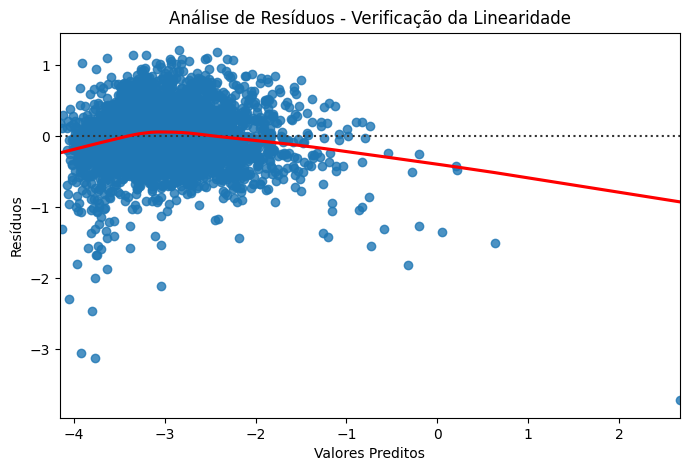

In [32]:
house_sales_data_modelo_normalizado['price'] = house_sales_data_modelo_normalizado['price'].replace(0, 1)
house_sales_data_modelo_normalizado['log_price'] = np.log(house_sales_data_modelo_normalizado['price'])

modelo = executar_regressao_linear(house_sales_data_modelo_normalizado, ['sqft_living', 'bedrooms', 'view', 'zipcode', 'lat'], 'log_price')

#### 5.2.2) Usando modelo de árvore de decisão

In [33]:
modelo_arvore, previsoes_arvore, metricas_arvore = executar_arvore_decisao(house_sales_data_modelo_normalizado, ['sqft_living', 'bedrooms', 'view', 'zipcode', 'lat'], 'price', max_depth=5)


Indicadores do Modelo de Árvore de Decisão:
🔹 Mean Absolute Error (MAE): 0.02
🔹 Mean Squared Error (MSE): 0.00
🔹 Root Mean Squared Error (RMSE): 0.03
🔹 R² Score: 0.6292


#### 5.2.3) Usando modelo de random forest

In [34]:
modelo_rf, previsoes_rf, metricas_rf = executar_random_forest(house_sales_data_modelo_normalizado, ['sqft_living', 'bedrooms', 'view', 'zipcode', 'lat'], 'price', n_estimators=100, max_depth=10)


Indicadores do Modelo Random Forest:
🔹 MAE: 0.01
🔹 MSE: 0.00
🔹 RMSE: 0.02
🔹 R² Score: 0.7838


---

**Comparação entre Modelos: Regressão Linear vs. Log(Price) vs. Árvore de Decisão vs. Random Forest**

| Indicador  | **Regressão Linear** | **Log(Price) - Regressão Linear** | **Árvore de Decisão** | **Random Forest** | **Melhor Modelo** |
|------------|--------------------|----------------|----------------|----------------|----------------|
| **MAE**    | **0.02**            | **0.29**       | **0.02**       | **0.01**       | ✅ **Random Forest** |
| **MSE**    | **0.00**            | **0.15**       | **0.00**       | **0.00**       | 🔹 Igual |
| **RMSE**   | **0.03**            | **0.39**       | **0.03**       | **0.02**       | ✅ **Random Forest** |
| **R² Score** | **0.6143**        | **0.6512**     | **0.6292**     | **0.7838**     | ✅ **Random Forest** |

---

O modelo **Random Forest** apresentou o melhor desempenho entre as abordagens testadas, com **menor erro absoluto (MAE = 0.01)** e **maior poder explicativo (R² = 0.7838)**. Em comparação, a **regressão linear tradicional e a regressão com transformação logarítmica** explicaram menos da variação do preço (R² de **0.6143 e 0.6512**, respectivamente), enquanto a **Árvore de Decisão** teve um leve ganho, mas ainda com maior risco de overfitting. O **Random Forest se destacou por combinar várias árvores de decisão**, reduzindo o overfitting e capturando melhor padrões complexos nos dados, tornando-se a melhor escolha para prever preços de imóveis com maior precisão e robustez. Portanto, recomendamos a utilização do **Random Forest** para esse problema, pois ele equilibra **baixo erro e alto poder preditivo**, fornecendo um modelo mais confiável.

---

## 6) Tomada de decisão

---

**Aplicação dos Resultados do Modelo Random Forest no Contexto de Negócios**

O modelo **Random Forest** pode ser aplicado em diversos contextos estratégicos do mercado imobiliário, permitindo tomadas de decisão mais informadas e baseadas em dados. Como o modelo demonstrou **alta precisão na previsão de preços**, ele pode ser utilizado para otimizar estratégias de precificação, investimentos e alocação de recursos.

**Exemplos de Decisões Estratégicas com Base nas Previsões**  

1. **Precificação Inteligente de Imóveis**  
   - Incorporadoras e imobiliárias podem utilizar o modelo para **definir preços competitivos** de venda e aluguel, considerando fatores como localização, tamanho, número de quartos e vistas privilegiadas.  
   - Corretores podem estimar um **preço justo de mercado**, evitando subprecificação (perda de valor) ou sobreprecificação (dificuldade de venda).

2. **Investimentos e Valorização de Áreas**  
   - Investidores podem identificar **regiões com maior potencial de valorização**, avaliando o impacto de variáveis como proximidade a infraestrutura urbana e qualidade dos imóveis.  
   - Construtoras podem usar as previsões para determinar quais características (ex.: número de quartos, área construída) agregam mais valor aos empreendimentos.

3. **Personalização de Ofertas e Marketing Direcionado**  
   - Plataformas imobiliárias podem recomendar imóveis de acordo com o perfil do comprador, mostrando **opções que oferecem o melhor custo-benefício** com base nas previsões do modelo.  
   - Campanhas de marketing podem ser ajustadas para focar em imóveis com **preço ideal para determinados perfis de clientes**.

4. **Avaliação de Viabilidade para Financiamentos e Seguros**  
   - Bancos e instituições financeiras podem utilizar as previsões para **calcular valores de empréstimos imobiliários**, garantindo que o financiamento esteja alinhado com o valor real do imóvel.  
   - Empresas de seguros podem ajustar **prêmios de seguro residencial**, considerando o valor estimado do imóvel.

**Conclusão**
A implementação desse modelo possibilita um **planejamento estratégico mais eficiente no setor imobiliário**, garantindo decisões baseadas em **dados reais e previsões precisas**. Dessa forma, empresas podem **reduzir riscos, otimizar lucros e oferecer melhores produtos e serviços** para clientes e investidores.  

---